# Exploratory Data Analysis

Import the required modules

In [1]:
import os
import h5py 
import pandas as pd
import numpy as np
import glob
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import matplotlib.pyplot as plt

ImportError: cannot import name 'BlobServiceClient' from 'azure.storage.blob' (/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/azure/storage/blob/__init__.py)

Set the local path directory for all downloaded data

In [2]:
DATA_DIR='../data/'
SEVIR_DIR=DATA_DIR + 'sevir/'
STORM_EVENT_DIR = DATA_DIR + 'storm_event/'

a. Read and clean the metadata

In [3]:
# Read catalog csv and saved in dataframe

event_catalog_df = pd.read_csv(SEVIR_DIR + 'CATALOG.csv', low_memory=False)
print(event_catalog_df.shape)

(76004, 21)


In [4]:
# Rename dataframe columns name

event_catalog_df.columns = [x.upper() for x in event_catalog_df.columns]

In [5]:
# Drop NaN values

event_catalog_df = event_catalog_df.dropna()
print(event_catalog_df.shape)

(13341, 21)


In [6]:
# Change the primary column datatype

event_catalog_df['EVENT_ID'] = event_catalog_df['EVENT_ID'].astype(int)
print("Metadata processed and changed into a dataframe")

Metadata processed and changed into a dataframe


b. Read and plot the data files

In [7]:
data_dirs = [x[0] for x in os.walk(DATA_DIR)]

In [8]:
# Define a define a dataframe for data files. Also creating a new column img_type

event_image_df = pd.DataFrame(columns = ['event_id', 'img_type', 'image'])
img_types = []

In [9]:
# Read and store the data files into a dataframe

for d in data_dirs:
    img_type = d[d.rindex("/") + 1:]
    filenames = glob.glob(d + "/*.h5")
    if not filenames:
        continue

    img_types.append(img_type)
    print(img_type, filenames)
    
    for file in filenames:
        hf = h5py.File(file, 'r')
        for idx in range(hf['id'].shape[0]):
            event_id = float(hf['id'][idx].decode('UTF-8')[1:])
            event_image_df = event_image_df.append({'EVENT_ID' : event_id, 'img_type' : img_type, 'image' : hf[img_type][idx]}, ignore_index=True)

vil ['../data/sevir/vil/SEVIR_VIL_STORMEVENTS_2017_0101_0630.h5', '../data/sevir/vil/SEVIR_VIL_STORMEVENTS_2019_0701_1231.h5', '../data/sevir/vil/SEVIR_VIL_STORMEVENTS_2017_0701_1231.h5']
vis ['../data/sevir/vis/SEVIR_VIS_STORMEVENTS_2018_0101_0131.h5', '../data/sevir/vis/SEVIR_VIS_STORMEVENTS_2019_0101_0131.h5', '../data/sevir/vis/SEVIR_VIS_STORMEVENTS_2019_0201_0228.h5', '../data/sevir/vis/SEVIR_VIS_STORMEVENTS_2018_1201_1231.h5']
ir107 ['../data/sevir/ir107/SEVIR_IR107_STORMEVENTS_2018_0101_0630.h5', '../data/sevir/ir107/SEVIR_IR107_STORMEVENTS_2019_0101_0630.h5', '../data/sevir/ir107/SEVIR_IR107_RANDOMEVENTS_2019_0101_0430.h5', '../data/sevir/ir107/SEVIR_IR107_RANDOMEVENTS_2018_0101_0430.h5']
ir069 ['../data/sevir/ir069/SEVIR_IR069_STORMEVENTS_2018_0101_0630.h5', '../data/sevir/ir069/SEVIR_IR069_STORMEVENTS_2019_0101_0630.h5', '../data/sevir/ir069/SEVIR_IR069_RANDOMEVENTS_2019_0101_0430.h5', '../data/sevir/ir069/SEVIR_IR069_RANDOMEVENTS_2018_0101_0430.h5']


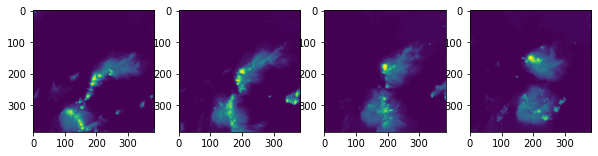

In [12]:
# Changing dataframe row into a 1D and plot a row of ir069 data images through Matplotlib

arr = event_image_df.iloc[0]['image']

#arr = arr.ravel()
#arr = arr.reshape(192, 192, 49)

fig,axs=plt.subplots(1,4,figsize=(10,5))
axs[0].imshow(arr[:,:,10])
axs[1].imshow(arr[:,:,20])
axs[2].imshow(arr[:,:,30])
axs[3].imshow(arr[:,:,40])

c. Read and clean the storm events data files

In [13]:
# Unzip all storm events files and store in a data frame

column_set = set()
df_list = []
for f in glob.glob(STORM_EVENT_DIR + '*.csv.gz'):
    df = pd.read_csv(f, compression='gzip', error_bad_lines=False, low_memory=False)
    if len(column_set) == 0:
        column_set.update(set(df.columns))
        df_list.append(df)
    elif column_set == set(df.columns):
        df_list.append(df)

storm_events_df = pd.concat(df_list)

In [14]:
# Drop index from the dataframe

storm_events_df.drop(storm_events_df.columns[0], axis=1, inplace=True)

In [15]:
# Rename dataframe column name

storm_events_df.columns = [x.upper() for x in storm_events_df.columns]

In [16]:
# Reset dataframe index

storm_events_df.reset_index(drop=True, inplace=True)
print(storm_events_df.shape)

(1602920, 50)


d. Join the sevir data frame and catalog data frame

In [17]:
# Join both the dataframe on Event_Id

data_df = pd.merge(event_catalog_df, event_image_df,  how='inner', on=['EVENT_ID'])
print(data_df.shape)

(15229, 24)


e. Now, join the new data frame with storm events data frmae to get all weather information together

In [18]:
joined_data_df = pd.merge(data_df, storm_events_df,  how='inner', on=['EVENT_ID'])
print(joined_data_df.shape)

(15229, 73)
